<a href="https://colab.research.google.com/github/JudahGazit/ColabNotebooks/blob/main/zoomout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U networkx scipy
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.2 MB/s eta 0:00:00


In [2]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 54.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 29.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.1+cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.9/873.9 KB 27.0

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special
import scipy.sparse
import scipy.linalg

%matplotlib inline

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.transforms as T


In [6]:
def xi(laplacian, t):
    if isinstance(laplacian, np.ndarray):
        exp = scipy.linalg.expm(-t * laplacian)
    else:
        exp = torch.linalg.matrix_exp(-t * laplacian).cpu().numpy()
    rou_ = exp / np.trace(exp)
    diag_mat = (rou_.diagonal() * np.ones(laplacian.shape))
    rou_tag = rou_ / np.minimum(diag_mat, diag_mat.transpose())
    return ((rou_tag - 1) >= 0).astype(int)

def compress(graph, t, device=None):
    if isinstance(graph, nx.Graph):
        laplacian = nx.laplacian_matrix(graph).toarray()
    else:
        laplacian = torch.sparse_coo_tensor(*torch_geometric.utils.get_laplacian(graph.edge_index)).to_dense().to(device)
        graph = torch_geometric.utils.convert.to_networkx(graph, to_undirected=True)
    components = scipy.sparse.csgraph.connected_components(xi(laplacian, t))[1]
    mapping = {k: c for k, c in enumerate(components)}
    compressed = nx.relabel_nodes(graph, mapping)
    compressed.remove_edges_from(nx.selfloop_edges(compressed))
    return compressed, mapping


#BA-Demo

In [7]:
def draw_compressed(graph, pos, t, ax=None):
    ax = ax if ax is not None else plt.gca()
    compressed, mapping = compress(graph, t)

    pivot_mapping = [[] for _ in range(np.max(list(mapping.values())) + 1)]
    for k, v in mapping.items():
        pivot_mapping[v].append(k)
        
    pos_compress = {k: np.mean([pos[i] for i in v], 0) for k, v in enumerate(pivot_mapping)}
    nx.draw_networkx(compressed, pos_compress, with_labels=False, node_size=10, node_color='w', edgecolors='k', ax=ax)
    ax.text(0, 1, f'N={compressed.number_of_nodes()}')

In [5]:
graph = nx.random_graphs.barabasi_albert_graph(500, 1)

In [ ]:
comps = list(nx.connected_components(graph))
graph = nx.Graph(nx.convert_node_labels_to_integers(graph.subgraph(max(comps, key=len))))

In [ ]:
pos = nx.layout.spring_layout(graph)

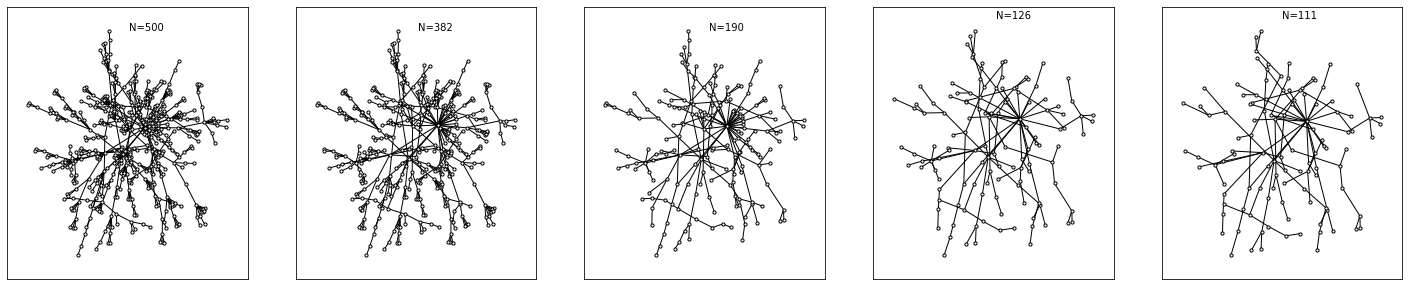

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(5 * 5, 5 * 1))
for t, ax in zip((0, 0.5, 1, 1.5, 2), axes):
    draw_compressed(graph, pos, t, ax)

# GNN

##TODO:
- [ ] Optimize `compress_dataset(...)` to skip the `networkx` and `mapping` part
- [ ] Refactor the usage in `GCN(...)`


In [36]:
import torch_geometric.utils.convert

def compress_dataset(data, t, transform, device=None):
    # g = torch_geometric.utils.convert.to_networkx(data, to_undirected=True)
    # degrees = torch.sparse_coo_tensor(data.edge_index, data.edge_weight).to_dense().sum(1).numpy()
    compressed, mapping = compress(data, t, device)

    pivot_mapping = [[] for _ in range(np.max(list(mapping.values())) + 1)]
    for k, v in mapping.items():
        pivot_mapping[v].append(k)

    compress_matrix = np.zeros((len(pivot_mapping), len(mapping)))
    for i, row in enumerate(pivot_mapping):
        for j in row:
            # compress_matrix[i][j] = degrees[j] / degrees[row].sum()
            compress_matrix[i][j] = 1 / len(row)
    invert_compress_matrix = torch.tensor((compress_matrix.transpose() > 0).astype(float), dtype=torch.float).to_sparse()
    compress_matrix = torch.tensor(compress_matrix, dtype=torch.float).to_sparse()

    data_compressed = torch_geometric.utils.convert.from_networkx(compressed)
    data_compressed = transform(data_compressed)
    data_compressed['compress_matrix'] = compress_matrix
    data_compressed['invert_compress_matrix'] = invert_compress_matrix
    return data_compressed

In [39]:
import torch_geometric.nn as gnn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, n_feat, n_classes, n_hidden, n_layers, dropout=0.5, mode='during'):
        super().__init__()
        self.convs = gnn.GCN(n_feat, n_hidden, n_layers + 2, dropout=dropout)
        self.dense = gnn.MLP([n_hidden, n_classes])
        self.alpha = nn.Parameter(torch.zeros(1))
        self.mode = mode
        self.temprature = 10
        self.temprature_decay = 0.99

    def forward_conv(self, conv, x, data, data_compressed):
        if data_compressed is None:
            x = conv(x, data.edge_index, data.edge_weight)
        else:
            alpha = torch.sigmoid(self.alpha)
            x_compressed = conv(data_compressed.compress_matrix @ x, data_compressed.edge_index, data_compressed.edge_weight)
            x = conv(x, data.edge_index, data.edge_weight)
            x = alpha * x + (1 - alpha) * (data_compressed.invert_compress_matrix @ x_compressed)
        return x

    def forward_gcn(self, x, data, data_compressed=None):
        x = self.convs(x, data.edge_index)
        return x

    def forward(self, data, data_compressed=None):
        x = data.x
        
        if self.mode == 'during':
            x = self.forward_gcn(x, data, data_compressed)
        elif self.mode == 'after':
            if self.training:
                self.temprature = self.temprature * self.temprature_decay
                data_compressed = compress_dataset(data, np.random.rand() * self.temprature, transform, device).to(device)
                x = self.forward_gcn(data_compressed.compress_matrix @ x, data_compressed)
                x = data_compressed.invert_compress_matrix @ x
            else:
                x = self.forward_gcn(x, data)
            # alpha = torch.sigmoid(self.alpha)
            # x_compressed = data_compressed.invert_compress_matrix @ x_compressed
            # x = alpha * x + (1 - alpha) * x_compressed
            # x = x_compressed
            # x = torch.cat([x, x_compressed], dim=1)
        x = self.dense(x)
        return F.log_softmax(x, dim=1)

In [ ]:
from torch_geometric.datasets import Planetoid
transform = T.Compose([T.AddSelfLoops(), T.NormalizeFeatures(), T.GCNNorm()])
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=transform, split="random", num_val=500, num_test=500)
# dataset = Planetoid(root='/tmp/CiteSeer', name='CiteSeer', transform=transform, split="random", num_val=600, num_test=600)
# dataset = Planetoid(root='/tmp/PubMed', name='PubMed', transform=transform, split="random", num_val=600, num_test=600)

In [40]:
def train(model, optimizer, data, data_compressed):
    model.train()
    optimizer.zero_grad()
    out = model(data, data_compressed)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def evaluate(model, optimizer, data, data_compressed, best_val, epoch, model_path):
    model.eval()
    alpha = torch.sigmoid(model.alpha).cpu().detach().numpy()[0]
    pred = model(data, data_compressed)
    train_loss = F.nll_loss(pred[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(pred[data.val_mask], data.y[data.val_mask])
    train_acc = (pred.argmax(dim=1)[data.train_mask] == data.y[data.train_mask]).float().mean()
    val_acc = (pred.argmax(dim=1)[data.val_mask] == data.y[data.val_mask]).float().mean()
    if val_acc > best_val or epoch % 5 == 0:
        best_val = val_acc
        best_params = torch.save(model.state_dict(), model_path)
        log = f'Epoch {epoch:4d} | Alpha {alpha:.2f} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}'
        print("\r", log, end="")
    return best_val

In [42]:
MODEL_PATH = 'model_params'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, dataset.num_classes, 64, 0, dropout=0.5, mode='after').to(device)
data = dataset[0].to(device)
data['train_mask'] = (~data.val_mask & ~data.test_mask)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
data_compressed = compress_dataset(dataset[0], 1, transform, device).to(device)

best_val = 0
for epoch in range(500):
    train(model, optimizer, data, data_compressed)
    best_val = evaluate(model, optimizer, data, data_compressed, best_val, epoch, model_path=MODEL_PATH)

print()
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()
test_acc = (model(data, data_compressed).argmax(1)[data.test_mask] == data.y[data.test_mask]).float().mean().cpu()
print('Test Accuracy=', test_acc.numpy())

 Epoch  496 | Alpha 0.50 | Train Loss: 0.1611 | Val Loss: 0.3111 | Train Accuracy: 0.9543 | Val Accuracy: 0.8980
Test Accuracy= 0.874


In [ ]:
#Transfer learning

def evaluate_transfer(model, optimizer, data, data_compressed, best_val, epoch, model_path):
    model.eval()
    pred = model(data, data_compressed)
    pred = F.log_softmax(pred, dim=1)
    train_loss = F.nll_loss(pred[data.train_mask], data.y[data.train_mask])
    val_loss = F.nll_loss(pred[data.val_mask], data.y[data.val_mask])
    train_acc = (pred.argmax(dim=1)[data.train_mask] == data.y[data.train_mask]).float().mean()
    val_acc = (pred.argmax(dim=1)[data.val_mask] == data.y[data.val_mask]).float().mean()
    if val_acc > best_val or epoch % 5 == 0:
        best_val = val_acc
        best_params = torch.save(model.state_dict(), model_path)
        log = f'Epoch {epoch:4d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}'
        print("\r", log, end="")
    return best_val

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_node_features, dataset.num_classes, 64, 0, dropout=0.5, mode='after').to(device)
# model = gnn.GCN(data.num_node_features, 64, 0, out_channels=dataset.num_classes, dropout=0.5).to(device)
# data_compressed = compress_dataset(dataset[0], 2, transform).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=0)
best_val = 0
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data, data_compressed)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    best_val = evaluate_transfer(model, optimizer, data, data_compressed, best_val, epoch, model_path=MODEL_PATH)

print()
model.load_state_dict(torch.load(MODEL_PATH))

optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-3)
best_val = 0
for epoch in range(1500):
    model.train()
    optimizer.zero_grad()
    out = model(data, data_compressed)
    out = F.log_softmax(out, dim=1)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    best_val = evaluate_transfer(model, optimizer, data, data_compressed, best_val, epoch, model_path=MODEL_PATH)

print()
model.load_state_dict(torch.load(MODEL_PATH))

model.eval()
test_acc = (F.log_softmax(model(data.x, data.edge_index), dim=1).argmax(1)[data.test_mask] == data.y[data.test_mask]).float().mean().cpu()
print('Test Accuracy=', test_acc.numpy())


 Epoch  998 | Train Loss: 0.0144 | Val Loss: 2.5824 | Train Accuracy: 0.9953 | Val Accuracy: 0.8280
 Epoch 1497 | Train Loss: 0.1901 | Val Loss: 0.4415 | Train Accuracy: 0.9502 | Val Accuracy: 0.8800


AttributeError: ignored

In [ ]:
Cora

{'n_hidden': 120,
 'n_layers': 0,
 'lr': 0.04404652097610471,
 'weight_decay': 0.0009545466683623879}

 {'n_layers': 0,
  'n_hidden': 16,
 'lr': 0.044403241891029975,
 'weight_decay': 0.0005671747369860281}

 {'n_hidden': 64, 'lr': 0.07175600104008818, 'weight_decay': 0.0009942902349416394}

CiteSeer
{'lr': 0.0835075227222568,
 'weight_decay': 0.001710089468601641,
 'dropout': 0.499862317157423}

 {'tau': 13.290970428418092,
 'lr': 0.046263519731511056,
 'weight_decay': 0.00025748540894850587}

In [ ]:
import optuna

MODEL_PATH = 'model_params'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def objective(trial): 
    # n_hidden = trial.suggest_int('n_hidden', 16, 128)
    # n_layers = trial.suggest_int('n_layers', 0, 8)
    tau = trial.suggest_float('tau', 0, 100)
    lr = trial.suggest_float('lr', 0.001, 0.1)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    model = GCN(dataset.num_node_features, dataset.num_classes, 64, 0, dropout=0.9, mode='after').to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    data_compressed = compress_dataset(dataset[0], tau, transform, device).to(device)
    best_val = 0
    for epoch in range(500):
        train(model, optimizer, data, data_compressed)
        best_val = evaluate(model, optimizer, data, data_compressed, best_val, epoch, model_path=MODEL_PATH)
    return -best_val

study = optuna.create_study()
study.optimize(objective, n_trials=100)

study.best_params

[I 2023-02-25 17:09:34,072] A new study created in memory with name: no-name-8387d747-ceda-4d3f-be29-95271790ef3d


 Epoch   17 | Alpha 0.53 | Train Loss: 1.7568 | Val Loss: 1.7423 | Train Accuracy: 0.2431 | Val Accuracy: 0.2817

[I 2023-02-25 17:09:44,318] Trial 0 finished with value: -0.28166666626930237 and parameters: {'tau': 52.950455286621676, 'lr': 0.07655562938152745, 'weight_decay': 0.00973442924063137}. Best is trial 0 with value: -0.28166666626930237.


 Epoch   79 | Alpha 0.54 | Train Loss: 1.7579 | Val Loss: 1.7416 | Train Accuracy: 0.2454 | Val Accuracy: 0.2733

[I 2023-02-25 17:09:54,220] Trial 1 finished with value: -0.273333340883255 and parameters: {'tau': 46.590895342436426, 'lr': 0.04566037361912515, 'weight_decay': 0.005864847019772606}. Best is trial 0 with value: -0.28166666626930237.


 Epoch    4 | Alpha 0.51 | Train Loss: 1.7650 | Val Loss: 1.7551 | Train Accuracy: 0.2031 | Val Accuracy: 0.2450

[I 2023-02-25 17:10:03,811] Trial 2 finished with value: -0.24500000476837158 and parameters: {'tau': 22.080385477254826, 'lr': 0.009846047633183086, 'weight_decay': 0.009742279540300394}. Best is trial 0 with value: -0.28166666626930237.


 Epoch   20 | Alpha 0.56 | Train Loss: 1.7523 | Val Loss: 1.7363 | Train Accuracy: 0.2882 | Val Accuracy: 0.3100

[I 2023-02-25 17:10:15,290] Trial 3 finished with value: -0.3100000023841858 and parameters: {'tau': 98.43183156574496, 'lr': 0.0691446418211794, 'weight_decay': 0.0035716325973728902}. Best is trial 3 with value: -0.3100000023841858.


 Epoch   73 | Alpha 0.61 | Train Loss: 1.7567 | Val Loss: 1.7403 | Train Accuracy: 0.2736 | Val Accuracy: 0.2967

[I 2023-02-25 17:10:26,283] Trial 4 finished with value: -0.29666668176651 and parameters: {'tau': 36.96841975004779, 'lr': 0.04574223881300651, 'weight_decay': 0.004679494949788292}. Best is trial 3 with value: -0.3100000023841858.


 Epoch  130 | Alpha 0.59 | Train Loss: 1.7560 | Val Loss: 1.7403 | Train Accuracy: 0.2863 | Val Accuracy: 0.3167

[I 2023-02-25 17:10:36,131] Trial 5 finished with value: -0.3166666626930237 and parameters: {'tau': 45.512453976921286, 'lr': 0.04150283409528433, 'weight_decay': 0.002691932249356482}. Best is trial 5 with value: -0.3166666626930237.


 Epoch  154 | Alpha 0.53 | Train Loss: 1.7578 | Val Loss: 1.7430 | Train Accuracy: 0.2417 | Val Accuracy: 0.2750

[I 2023-02-25 17:10:45,419] Trial 6 finished with value: -0.2750000059604645 and parameters: {'tau': 71.68009001829874, 'lr': 0.053984584565976115, 'weight_decay': 0.0037592082114575103}. Best is trial 5 with value: -0.3166666626930237.


 Epoch   24 | Alpha 0.58 | Train Loss: 1.7536 | Val Loss: 1.7388 | Train Accuracy: 0.2666 | Val Accuracy: 0.2800

[I 2023-02-25 17:10:55,344] Trial 7 finished with value: -0.2800000011920929 and parameters: {'tau': 31.885372793028733, 'lr': 0.05157345317779064, 'weight_decay': 0.006475793799380215}. Best is trial 5 with value: -0.3166666626930237.


 Epoch    1 | Alpha 0.50 | Train Loss: 1.7684 | Val Loss: 1.7604 | Train Accuracy: 0.2031 | Val Accuracy: 0.2450

[I 2023-02-25 17:11:05,644] Trial 8 finished with value: -0.24500000476837158 and parameters: {'tau': 75.86837567687378, 'lr': 0.03310814931457103, 'weight_decay': 0.009853200943127438}. Best is trial 5 with value: -0.3166666626930237.


 Epoch  122 | Alpha 0.61 | Train Loss: 1.7505 | Val Loss: 1.7364 | Train Accuracy: 0.2858 | Val Accuracy: 0.3233

[I 2023-02-25 17:11:15,254] Trial 9 finished with value: -0.32333335280418396 and parameters: {'tau': 80.23960618892511, 'lr': 0.02852760182931873, 'weight_decay': 0.0020627836600702032}. Best is trial 9 with value: -0.32333335280418396.


 Epoch   17 | Alpha 0.49 | Train Loss: 0.4901 | Val Loss: 0.7459 | Train Accuracy: 0.8270 | Val Accuracy: 0.7683

[I 2023-02-25 17:11:29,250] Trial 10 finished with value: -0.768333375453949 and parameters: {'tau': 0.11109738940865554, 'lr': 0.09125561933731391, 'weight_decay': 4.705518709812763e-05}. Best is trial 10 with value: -0.768333375453949.


 Epoch  138 | Alpha 0.50 | Train Loss: 0.5028 | Val Loss: 0.7411 | Train Accuracy: 0.8181 | Val Accuracy: 0.7533

[I 2023-02-25 17:11:42,854] Trial 11 finished with value: -0.753333330154419 and parameters: {'tau': 0.2015196831007574, 'lr': 0.09074720333409608, 'weight_decay': 9.673909426502871e-05}. Best is trial 10 with value: -0.768333375453949.


 Epoch  369 | Alpha 0.61 | Train Loss: 0.7736 | Val Loss: 0.9304 | Train Accuracy: 0.7645 | Val Accuracy: 0.7283

[I 2023-02-25 17:11:54,094] Trial 12 finished with value: -0.7283333539962769 and parameters: {'tau': 1.550311232424936, 'lr': 0.09858068695721044, 'weight_decay': 2.3386700258270772e-05}. Best is trial 10 with value: -0.768333375453949.


 Epoch  101 | Alpha 0.75 | Train Loss: 1.3342 | Val Loss: 1.3477 | Train Accuracy: 0.6601 | Val Accuracy: 0.6650

[I 2023-02-25 17:12:05,169] Trial 13 finished with value: -0.6650000214576721 and parameters: {'tau': 3.0934358233257626, 'lr': 0.09857351605513984, 'weight_decay': 0.0010697317115338514}. Best is trial 10 with value: -0.768333375453949.


 Epoch  115 | Alpha 0.74 | Train Loss: 0.8037 | Val Loss: 0.9238 | Train Accuracy: 0.7960 | Val Accuracy: 0.7533

[I 2023-02-25 17:12:15,593] Trial 14 finished with value: -0.753333330154419 and parameters: {'tau': 11.785228378566142, 'lr': 0.08557669937846, 'weight_decay': 0.0001326495681108685}. Best is trial 10 with value: -0.768333375453949.


 Epoch   98 | Alpha 0.89 | Train Loss: 1.2949 | Val Loss: 1.3124 | Train Accuracy: 0.6526 | Val Accuracy: 0.6367

[I 2023-02-25 17:12:25,636] Trial 15 finished with value: -0.6366666555404663 and parameters: {'tau': 15.44035323555234, 'lr': 0.0845918593549295, 'weight_decay': 0.001342062360958391}. Best is trial 10 with value: -0.768333375453949.


 Epoch  431 | Alpha 0.60 | Train Loss: 0.4500 | Val Loss: 0.8512 | Train Accuracy: 0.8622 | Val Accuracy: 0.7600

[I 2023-02-25 17:12:38,045] Trial 16 finished with value: -0.7599999904632568 and parameters: {'tau': 0.7994602666797537, 'lr': 0.06568310326174982, 'weight_decay': 3.660022865853519e-05}. Best is trial 10 with value: -0.768333375453949.


 Epoch   52 | Alpha 0.84 | Train Loss: 1.1603 | Val Loss: 1.1745 | Train Accuracy: 0.7160 | Val Accuracy: 0.6950

[I 2023-02-25 17:12:47,304] Trial 17 finished with value: -0.6949999928474426 and parameters: {'tau': 23.676354803376412, 'lr': 0.06660297929622393, 'weight_decay': 0.001078451256548769}. Best is trial 10 with value: -0.768333375453949.


 Epoch  480 | Alpha 0.90 | Train Loss: 1.2690 | Val Loss: 1.2777 | Train Accuracy: 0.7043 | Val Accuracy: 0.6850

[I 2023-02-25 17:12:57,564] Trial 18 finished with value: -0.6850000023841858 and parameters: {'tau': 13.230900589510293, 'lr': 0.06430125851617188, 'weight_decay': 0.002393715937807715}. Best is trial 10 with value: -0.768333375453949.


 Epoch  104 | Alpha 0.82 | Train Loss: 1.2487 | Val Loss: 1.2448 | Train Accuracy: 0.7193 | Val Accuracy: 0.7183

[I 2023-02-25 17:13:07,515] Trial 19 finished with value: -0.71833336353302 and parameters: {'tau': 23.784619013365997, 'lr': 0.07785891985691887, 'weight_decay': 0.001513184065081209}. Best is trial 10 with value: -0.768333375453949.


 Epoch   79 | Alpha 0.90 | Train Loss: 1.3837 | Val Loss: 1.3833 | Train Accuracy: 0.6013 | Val Accuracy: 0.5800

[I 2023-02-25 17:13:16,998] Trial 20 finished with value: -0.5800000429153442 and parameters: {'tau': 9.008034923966248, 'lr': 0.060959949717458335, 'weight_decay': 0.00318153707057965}. Best is trial 10 with value: -0.768333375453949.


 Epoch  288 | Alpha 0.54 | Train Loss: 0.5073 | Val Loss: 0.7771 | Train Accuracy: 0.8477 | Val Accuracy: 0.7583

[I 2023-02-25 17:13:30,912] Trial 21 finished with value: -0.7583333253860474 and parameters: {'tau': 0.34918284022860435, 'lr': 0.08808263241177827, 'weight_decay': 0.00013791482148991238}. Best is trial 10 with value: -0.768333375453949.


 Epoch  189 | Alpha 0.52 | Train Loss: 0.5177 | Val Loss: 0.6940 | Train Accuracy: 0.8364 | Val Accuracy: 0.7833

[I 2023-02-25 17:13:43,465] Trial 22 finished with value: -0.7833333611488342 and parameters: {'tau': 0.5856726931648863, 'lr': 0.07667418906016402, 'weight_decay': 0.0008060571308549161}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  137 | Alpha 0.86 | Train Loss: 1.0080 | Val Loss: 1.0448 | Train Accuracy: 0.7767 | Val Accuracy: 0.7633

[I 2023-02-25 17:13:53,741] Trial 23 finished with value: -0.7633333802223206 and parameters: {'tau': 8.828512806029815, 'lr': 0.07603276127636288, 'weight_decay': 0.0008128165657176279}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  483 | Alpha 0.83 | Train Loss: 1.3390 | Val Loss: 1.3326 | Train Accuracy: 0.6385 | Val Accuracy: 0.6633

[I 2023-02-25 17:14:04,317] Trial 24 finished with value: -0.6633333563804626 and parameters: {'tau': 9.521371920803889, 'lr': 0.07574882274155506, 'weight_decay': 0.0016713952387605482}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  140 | Alpha 0.86 | Train Loss: 1.1615 | Val Loss: 1.1826 | Train Accuracy: 0.7137 | Val Accuracy: 0.7100

[I 2023-02-25 17:14:14,575] Trial 25 finished with value: -0.7100000381469727 and parameters: {'tau': 17.15410378905111, 'lr': 0.0786523789109214, 'weight_decay': 0.0009576376677234366}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  349 | Alpha 0.86 | Train Loss: 1.5484 | Val Loss: 1.5425 | Train Accuracy: 0.5261 | Val Accuracy: 0.5450

[I 2023-02-25 17:14:24,400] Trial 26 finished with value: -0.5450000166893005 and parameters: {'tau': 8.857895644019557, 'lr': 0.09175863261242126, 'weight_decay': 0.0019259287507650432}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  173 | Alpha 0.81 | Train Loss: 0.9018 | Val Loss: 0.9445 | Train Accuracy: 0.7861 | Val Accuracy: 0.7683

[I 2023-02-25 17:14:34,141] Trial 27 finished with value: -0.768333375453949 and parameters: {'tau': 18.01359733268487, 'lr': 0.07134489496510502, 'weight_decay': 0.0007489368359553281}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   41 | Alpha 0.54 | Train Loss: 1.7538 | Val Loss: 1.7398 | Train Accuracy: 0.2633 | Val Accuracy: 0.2950

[I 2023-02-25 17:14:44,561] Trial 28 finished with value: -0.29500001668930054 and parameters: {'tau': 19.226889439508682, 'lr': 0.05720664031676626, 'weight_decay': 0.0025558613308972514}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  136 | Alpha 0.82 | Train Loss: 1.1143 | Val Loss: 1.1497 | Train Accuracy: 0.7607 | Val Accuracy: 0.7283

[I 2023-02-25 17:14:54,676] Trial 29 finished with value: -0.7283333539962769 and parameters: {'tau': 30.61870738879417, 'lr': 0.0703054624952757, 'weight_decay': 0.0006251936970337255}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  370 | Alpha 0.87 | Train Loss: 1.2193 | Val Loss: 1.2370 | Train Accuracy: 0.7706 | Val Accuracy: 0.7517

[I 2023-02-25 17:15:04,084] Trial 30 finished with value: -0.7549999952316284 and parameters: {'tau': 16.94030768661524, 'lr': 0.07326305077071084, 'weight_decay': 0.0016857190160193612}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  275 | Alpha 0.82 | Train Loss: 1.1313 | Val Loss: 1.1949 | Train Accuracy: 0.7847 | Val Accuracy: 0.7500

[I 2023-02-25 17:15:14,797] Trial 31 finished with value: -0.75 and parameters: {'tau': 6.578932788431078, 'lr': 0.08085534301633879, 'weight_decay': 0.0006792019449567554}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  177 | Alpha 0.82 | Train Loss: 1.0029 | Val Loss: 1.0621 | Train Accuracy: 0.7781 | Val Accuracy: 0.7683

[I 2023-02-25 17:15:26,524] Trial 32 finished with value: -0.768333375453949 and parameters: {'tau': 8.175789626146681, 'lr': 0.07259230216512028, 'weight_decay': 0.0007863076477262386}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   69 | Alpha 0.79 | Train Loss: 1.2004 | Val Loss: 1.2311 | Train Accuracy: 0.7005 | Val Accuracy: 0.6667

[I 2023-02-25 17:15:37,515] Trial 33 finished with value: -0.6666666865348816 and parameters: {'tau': 6.016809418441282, 'lr': 0.08188494827347018, 'weight_decay': 0.0014651943696915282}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  448 | Alpha 0.78 | Train Loss: 1.0140 | Val Loss: 1.0849 | Train Accuracy: 0.7898 | Val Accuracy: 0.7633

[I 2023-02-25 17:15:46,801] Trial 34 finished with value: -0.7633333802223206 and parameters: {'tau': 15.050754142570995, 'lr': 0.07417961475034844, 'weight_decay': 0.0005544982680074466}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  377 | Alpha 0.84 | Train Loss: 0.9896 | Val Loss: 1.0332 | Train Accuracy: 0.7800 | Val Accuracy: 0.7667

[I 2023-02-25 17:15:57,432] Trial 35 finished with value: -0.7666667103767395 and parameters: {'tau': 6.671735879336769, 'lr': 0.05992879397068509, 'weight_decay': 0.002044755208220044}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  293 | Alpha 0.85 | Train Loss: 1.2153 | Val Loss: 1.2359 | Train Accuracy: 0.7635 | Val Accuracy: 0.7550

[I 2023-02-25 17:16:07,551] Trial 36 finished with value: -0.7549999952316284 and parameters: {'tau': 22.60186973200511, 'lr': 0.06964455760468781, 'weight_decay': 0.0011767445190028947}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  191 | Alpha 0.86 | Train Loss: 1.5540 | Val Loss: 1.5460 | Train Accuracy: 0.5346 | Val Accuracy: 0.5267

[I 2023-02-25 17:16:17,587] Trial 37 finished with value: -0.5266667008399963 and parameters: {'tau': 13.440951019310148, 'lr': 0.09315191050698572, 'weight_decay': 0.0028580593070113456}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  326 | Alpha 0.78 | Train Loss: 0.9514 | Val Loss: 1.0101 | Train Accuracy: 0.7866 | Val Accuracy: 0.7667

[I 2023-02-25 17:16:27,822] Trial 38 finished with value: -0.7666667103767395 and parameters: {'tau': 5.43334017884002, 'lr': 0.08526702551612692, 'weight_decay': 0.0005639789074851539}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  217 | Alpha 0.87 | Train Loss: 1.4026 | Val Loss: 1.3973 | Train Accuracy: 0.6079 | Val Accuracy: 0.6117

[I 2023-02-25 17:16:37,834] Trial 39 finished with value: -0.6116666793823242 and parameters: {'tau': 28.587523341574705, 'lr': 0.08122516607968895, 'weight_decay': 0.0022627708806871143}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   11 | Alpha 0.54 | Train Loss: 1.7522 | Val Loss: 1.7339 | Train Accuracy: 0.2478 | Val Accuracy: 0.2733

[I 2023-02-25 17:16:47,906] Trial 40 finished with value: -0.273333340883255 and parameters: {'tau': 37.73907109188153, 'lr': 0.0627606954306396, 'weight_decay': 0.003593777743934888}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  444 | Alpha 0.85 | Train Loss: 1.4256 | Val Loss: 1.4288 | Train Accuracy: 0.6145 | Val Accuracy: 0.6200

[I 2023-02-25 17:16:58,570] Trial 41 finished with value: -0.6200000047683716 and parameters: {'tau': 6.167956330202696, 'lr': 0.07151266224698201, 'weight_decay': 0.0019958087481361303}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  414 | Alpha 0.51 | Train Loss: 0.6129 | Val Loss: 0.7320 | Train Accuracy: 0.8025 | Val Accuracy: 0.7717

[I 2023-02-25 17:17:12,513] Trial 42 finished with value: -0.7716667056083679 and parameters: {'tau': 0.018555611108611814, 'lr': 0.059426607287507385, 'weight_decay': 0.001367099193994548}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  107 | Alpha 0.51 | Train Loss: 0.5652 | Val Loss: 0.7412 | Train Accuracy: 0.8322 | Val Accuracy: 0.7733

[I 2023-02-25 17:17:26,351] Trial 43 finished with value: -0.7733333706855774 and parameters: {'tau': 0.03654770258429711, 'lr': 0.056251805945969124, 'weight_decay': 0.0013208201328059356}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  356 | Alpha 0.60 | Train Loss: 0.6785 | Val Loss: 0.7837 | Train Accuracy: 0.7889 | Val Accuracy: 0.7600

[I 2023-02-25 17:17:38,145] Trial 44 finished with value: -0.7599999904632568 and parameters: {'tau': 0.8915128420051985, 'lr': 0.053283009724048425, 'weight_decay': 0.0013600760209257314}. Best is trial 22 with value: -0.7833333611488342.


 Epoch    6 | Alpha 0.45 | Train Loss: 1.7145 | Val Loss: 1.6890 | Train Accuracy: 0.2863 | Val Accuracy: 0.3350

[I 2023-02-25 17:17:48,257] Trial 45 finished with value: -0.33500000834465027 and parameters: {'tau': 3.816514236119203, 'lr': 0.04347388684485705, 'weight_decay': 0.004580718240511376}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  137 | Alpha 0.80 | Train Loss: 0.5251 | Val Loss: 0.7159 | Train Accuracy: 0.8171 | Val Accuracy: 0.7733

[I 2023-02-25 17:17:58,516] Trial 46 finished with value: -0.7733333706855774 and parameters: {'tau': 11.634547288597489, 'lr': 0.049476348515760764, 'weight_decay': 0.0004351027114121381}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  473 | Alpha 0.89 | Train Loss: 0.8269 | Val Loss: 0.8974 | Train Accuracy: 0.7922 | Val Accuracy: 0.7783

[I 2023-02-25 17:18:08,809] Trial 47 finished with value: -0.7783333659172058 and parameters: {'tau': 11.823487121870457, 'lr': 0.04739938330896859, 'weight_decay': 0.001581966969128295}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   62 | Alpha 0.52 | Train Loss: 1.7583 | Val Loss: 1.7438 | Train Accuracy: 0.2675 | Val Accuracy: 0.2783

[I 2023-02-25 17:18:19,056] Trial 48 finished with value: -0.2783333361148834 and parameters: {'tau': 11.640449857197579, 'lr': 0.04618038131632267, 'weight_decay': 0.0030348446543163364}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  138 | Alpha 0.62 | Train Loss: 1.7512 | Val Loss: 1.7375 | Train Accuracy: 0.2962 | Val Accuracy: 0.3200

[I 2023-02-25 17:18:28,247] Trial 49 finished with value: -0.3199999928474426 and parameters: {'tau': 13.59742880389547, 'lr': 0.04855651730396328, 'weight_decay': 0.0023939411375743826}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  473 | Alpha 0.78 | Train Loss: 0.9150 | Val Loss: 0.9655 | Train Accuracy: 0.7743 | Val Accuracy: 0.7567

[I 2023-02-25 17:18:39,377] Trial 50 finished with value: -0.7566666603088379 and parameters: {'tau': 3.7402790994235193, 'lr': 0.04001245590036187, 'weight_decay': 0.0016084478012112335}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  191 | Alpha 0.56 | Train Loss: 0.3309 | Val Loss: 0.7609 | Train Accuracy: 0.8801 | Val Accuracy: 0.7683

[I 2023-02-25 17:18:52,535] Trial 51 finished with value: -0.768333375453949 and parameters: {'tau': 0.4120307377328132, 'lr': 0.0564499215827331, 'weight_decay': 0.000294118202979678}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  310 | Alpha 0.80 | Train Loss: 1.0080 | Val Loss: 1.0709 | Train Accuracy: 0.7804 | Val Accuracy: 0.7650

[I 2023-02-25 17:19:03,115] Trial 52 finished with value: -0.76500004529953 and parameters: {'tau': 4.621494599306816, 'lr': 0.0510988378213928, 'weight_decay': 0.0010683027498206172}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   42 | Alpha 0.85 | Train Loss: 0.6157 | Val Loss: 0.7525 | Train Accuracy: 0.8171 | Val Accuracy: 0.7817

[I 2023-02-25 17:19:13,274] Trial 53 finished with value: -0.7816666960716248 and parameters: {'tau': 11.185939453461106, 'lr': 0.057662265860915635, 'weight_decay': 0.0003876640879462083}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  177 | Alpha 0.81 | Train Loss: 0.8813 | Val Loss: 0.9571 | Train Accuracy: 0.7978 | Val Accuracy: 0.7717

[I 2023-02-25 17:19:22,672] Trial 54 finished with value: -0.7716667056083679 and parameters: {'tau': 20.18720290876114, 'lr': 0.05486663828538951, 'weight_decay': 0.00043800098585983747}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  461 | Alpha 0.86 | Train Loss: 0.8340 | Val Loss: 0.8970 | Train Accuracy: 0.7931 | Val Accuracy: 0.7717

[I 2023-02-25 17:19:33,191] Trial 55 finished with value: -0.7716667056083679 and parameters: {'tau': 11.151987710921748, 'lr': 0.05948318053285595, 'weight_decay': 0.001171084486130389}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  155 | Alpha 0.80 | Train Loss: 0.4482 | Val Loss: 0.7171 | Train Accuracy: 0.8575 | Val Accuracy: 0.7783

[I 2023-02-25 17:19:43,398] Trial 56 finished with value: -0.7783333659172058 and parameters: {'tau': 12.539185160319208, 'lr': 0.04935118427555514, 'weight_decay': 0.00032932761270309727}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  181 | Alpha 0.77 | Train Loss: 0.6061 | Val Loss: 0.7687 | Train Accuracy: 0.8453 | Val Accuracy: 0.7767

[I 2023-02-25 17:19:53,356] Trial 57 finished with value: -0.7766667008399963 and parameters: {'tau': 26.777358508653265, 'lr': 0.05171085415775384, 'weight_decay': 0.00030516501707310973}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   33 | Alpha 0.73 | Train Loss: 0.5227 | Val Loss: 0.7229 | Train Accuracy: 0.8270 | Val Accuracy: 0.7833

[I 2023-02-25 17:20:02,532] Trial 58 finished with value: -0.7833333611488342 and parameters: {'tau': 27.13745566320681, 'lr': 0.038718594355233, 'weight_decay': 2.5500166679255437e-05}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   74 | Alpha 0.79 | Train Loss: 0.4835 | Val Loss: 0.7130 | Train Accuracy: 0.8298 | Val Accuracy: 0.7750

[I 2023-02-25 17:20:12,873] Trial 59 finished with value: -0.7750000357627869 and parameters: {'tau': 26.548302731460396, 'lr': 0.04036964334253109, 'weight_decay': 0.00011877532454112024}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  110 | Alpha 0.82 | Train Loss: 0.5449 | Val Loss: 0.7412 | Train Accuracy: 0.8354 | Val Accuracy: 0.7800

[I 2023-02-25 17:20:22,904] Trial 60 finished with value: -0.7800000309944153 and parameters: {'tau': 21.310487409377778, 'lr': 0.035945383628155206, 'weight_decay': 0.00041010324323353974}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  336 | Alpha 0.81 | Train Loss: 0.5723 | Val Loss: 0.7536 | Train Accuracy: 0.8340 | Val Accuracy: 0.7800

[I 2023-02-25 17:20:32,590] Trial 61 finished with value: -0.7800000309944153 and parameters: {'tau': 20.917103594209493, 'lr': 0.03596673193389972, 'weight_decay': 0.00034006833454209537}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  105 | Alpha 0.84 | Train Loss: 0.5972 | Val Loss: 0.7332 | Train Accuracy: 0.8096 | Val Accuracy: 0.7733

[I 2023-02-25 17:20:42,308] Trial 62 finished with value: -0.7733333706855774 and parameters: {'tau': 20.93997490990185, 'lr': 0.03637001276633438, 'weight_decay': 0.0008186162138654504}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   27 | Alpha 0.68 | Train Loss: 0.6318 | Val Loss: 0.7458 | Train Accuracy: 0.7997 | Val Accuracy: 0.7700

[I 2023-02-25 17:20:52,265] Trial 63 finished with value: -0.7700000405311584 and parameters: {'tau': 16.638865057875556, 'lr': 0.030805523420348913, 'weight_decay': 9.262603124302201e-05}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  380 | Alpha 0.84 | Train Loss: 0.8198 | Val Loss: 0.8752 | Train Accuracy: 0.8054 | Val Accuracy: 0.7750

[I 2023-02-25 17:21:02,745] Trial 64 finished with value: -0.7750000357627869 and parameters: {'tau': 22.692335252932693, 'lr': 0.03589712139453434, 'weight_decay': 0.0009892994085194528}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  205 | Alpha 0.81 | Train Loss: 0.5354 | Val Loss: 0.7282 | Train Accuracy: 0.8317 | Val Accuracy: 0.7750

[I 2023-02-25 17:21:11,995] Trial 65 finished with value: -0.7750000357627869 and parameters: {'tau': 15.93464791915305, 'lr': 0.04449440719027795, 'weight_decay': 0.0004188834026255285}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   38 | Alpha 0.71 | Train Loss: 0.4907 | Val Loss: 0.7276 | Train Accuracy: 0.8312 | Val Accuracy: 0.7650

[I 2023-02-25 17:21:21,886] Trial 66 finished with value: -0.76500004529953 and parameters: {'tau': 19.162450652391804, 'lr': 0.02628621057172676, 'weight_decay': 2.824010399243935e-05}. Best is trial 22 with value: -0.7833333611488342.


 Epoch   98 | Alpha 0.83 | Train Loss: 0.6708 | Val Loss: 0.7790 | Train Accuracy: 0.8030 | Val Accuracy: 0.7800

[I 2023-02-25 17:21:33,089] Trial 67 finished with value: -0.7800000309944153 and parameters: {'tau': 24.669011571553796, 'lr': 0.04744307361271313, 'weight_decay': 0.0006534529597693884}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  281 | Alpha 0.86 | Train Loss: 0.5320 | Val Loss: 0.7155 | Train Accuracy: 0.8359 | Val Accuracy: 0.7750

[I 2023-02-25 17:21:43,276] Trial 68 finished with value: -0.7750000357627869 and parameters: {'tau': 34.61316644354052, 'lr': 0.0266405268564419, 'weight_decay': 0.0008479675060011609}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  185 | Alpha 0.88 | Train Loss: 1.3092 | Val Loss: 1.3086 | Train Accuracy: 0.6897 | Val Accuracy: 0.6800

[I 2023-02-25 17:21:52,572] Trial 69 finished with value: -0.6800000071525574 and parameters: {'tau': 26.65019349326358, 'lr': 0.06682202859275456, 'weight_decay': 0.001761438209423085}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  304 | Alpha 0.85 | Train Loss: 0.6529 | Val Loss: 0.7783 | Train Accuracy: 0.8044 | Val Accuracy: 0.7667

[I 2023-02-25 17:22:02,554] Trial 70 finished with value: -0.7666667103767395 and parameters: {'tau': 21.724144284299626, 'lr': 0.04250973998933755, 'weight_decay': 0.0007058887310633196}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  132 | Alpha 0.81 | Train Loss: 0.4272 | Val Loss: 0.7049 | Train Accuracy: 0.8552 | Val Accuracy: 0.7783

[I 2023-02-25 17:22:12,515] Trial 71 finished with value: -0.7783333659172058 and parameters: {'tau': 18.429552805426795, 'lr': 0.04713457382853585, 'weight_decay': 0.00034848793985736855}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  107 | Alpha 0.87 | Train Loss: 0.6979 | Val Loss: 0.7764 | Train Accuracy: 0.8054 | Val Accuracy: 0.7750

[I 2023-02-25 17:22:22,372] Trial 72 finished with value: -0.7750000357627869 and parameters: {'tau': 10.597303470456595, 'lr': 0.048696521764959914, 'weight_decay': 0.0010478233510582973}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  123 | Alpha 0.82 | Train Loss: 0.5426 | Val Loss: 0.7088 | Train Accuracy: 0.8392 | Val Accuracy: 0.7783

[I 2023-02-25 17:22:32,360] Trial 73 finished with value: -0.7783333659172058 and parameters: {'tau': 24.41622247343309, 'lr': 0.0450544150443505, 'weight_decay': 0.00047573518188414156}. Best is trial 22 with value: -0.7833333611488342.


 Epoch  201 | Alpha 0.83 | Train Loss: 0.4827 | Val Loss: 0.6869 | Train Accuracy: 0.8519 | Val Accuracy: 0.7850

[I 2023-02-25 17:22:42,496] Trial 74 finished with value: -0.7866666913032532 and parameters: {'tau': 14.994421626871997, 'lr': 0.03800005708061012, 'weight_decay': 0.0006700960640537413}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  347 | Alpha 0.85 | Train Loss: 0.5637 | Val Loss: 0.7132 | Train Accuracy: 0.8176 | Val Accuracy: 0.7750

[I 2023-02-25 17:22:52,697] Trial 75 finished with value: -0.7750000357627869 and parameters: {'tau': 14.779813991911649, 'lr': 0.03759550002268777, 'weight_decay': 0.000904247999120463}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  200 | Alpha 0.84 | Train Loss: 0.6654 | Val Loss: 0.7711 | Train Accuracy: 0.7964 | Val Accuracy: 0.7733

[I 2023-02-25 17:23:02,243] Trial 76 finished with value: -0.7733333706855774 and parameters: {'tau': 32.65019817699845, 'lr': 0.03933074964991025, 'weight_decay': 0.000695639472636927}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  471 | Alpha 0.88 | Train Loss: 0.8373 | Val Loss: 0.9135 | Train Accuracy: 0.7880 | Val Accuracy: 0.7550

[I 2023-02-25 17:23:12,312] Trial 77 finished with value: -0.7549999952316284 and parameters: {'tau': 8.161496786077244, 'lr': 0.03262881964403344, 'weight_decay': 0.0016455113294360508}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  218 | Alpha 0.84 | Train Loss: 0.8021 | Val Loss: 0.8764 | Train Accuracy: 0.7988 | Val Accuracy: 0.7650

[I 2023-02-25 17:23:22,769] Trial 78 finished with value: -0.76500004529953 and parameters: {'tau': 18.815304730676093, 'lr': 0.043019647575984206, 'weight_decay': 0.0012700253567531547}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  220 | Alpha 0.82 | Train Loss: 0.4522 | Val Loss: 0.6966 | Train Accuracy: 0.8416 | Val Accuracy: 0.7800

[I 2023-02-25 17:23:32,970] Trial 79 finished with value: -0.7833333611488342 and parameters: {'tau': 14.93630614052423, 'lr': 0.0342992038278389, 'weight_decay': 0.000568507547416243}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  443 | Alpha 0.82 | Train Loss: 0.4799 | Val Loss: 0.7016 | Train Accuracy: 0.8552 | Val Accuracy: 0.7817

[I 2023-02-25 17:23:42,563] Trial 80 finished with value: -0.7816666960716248 and parameters: {'tau': 15.309877236921645, 'lr': 0.03450306278970236, 'weight_decay': 0.0005851248357554062}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  145 | Alpha 0.83 | Train Loss: 0.4819 | Val Loss: 0.7044 | Train Accuracy: 0.8496 | Val Accuracy: 0.7767

[I 2023-02-25 17:23:52,571] Trial 81 finished with value: -0.7766667008399963 and parameters: {'tau': 15.230669155357793, 'lr': 0.034505089346514015, 'weight_decay': 0.0006074386129004171}. Best is trial 74 with value: -0.7866666913032532.


 Epoch   44 | Alpha 0.74 | Train Loss: 0.5123 | Val Loss: 0.7178 | Train Accuracy: 0.8425 | Val Accuracy: 0.7800

[I 2023-02-25 17:24:02,506] Trial 82 finished with value: -0.7800000309944153 and parameters: {'tau': 23.3820718851158, 'lr': 0.03089889152165198, 'weight_decay': 6.425050293302754e-05}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  325 | Alpha 0.85 | Train Loss: 0.9529 | Val Loss: 1.0167 | Train Accuracy: 0.7908 | Val Accuracy: 0.7717

[I 2023-02-25 17:24:12,896] Trial 83 finished with value: -0.7716667056083679 and parameters: {'tau': 20.92386445613806, 'lr': 0.039033804117856945, 'weight_decay': 0.0010453802913591582}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  376 | Alpha 0.83 | Train Loss: 0.4481 | Val Loss: 0.7171 | Train Accuracy: 0.8486 | Val Accuracy: 0.7783

[I 2023-02-25 17:24:22,419] Trial 84 finished with value: -0.7783333659172058 and parameters: {'tau': 9.179194995698754, 'lr': 0.03387257839296841, 'weight_decay': 0.0005617507524571855}. Best is trial 74 with value: -0.7866666913032532.


 Epoch   72 | Alpha 0.80 | Train Loss: 0.4304 | Val Loss: 0.6983 | Train Accuracy: 0.8514 | Val Accuracy: 0.7733

[I 2023-02-25 17:24:32,533] Trial 85 finished with value: -0.7733333706855774 and parameters: {'tau': 17.196498218171314, 'lr': 0.03767353060140635, 'weight_decay': 0.0002741224931019191}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  180 | Alpha 0.84 | Train Loss: 0.7572 | Val Loss: 0.8589 | Train Accuracy: 0.8082 | Val Accuracy: 0.7750

[I 2023-02-25 17:24:42,608] Trial 86 finished with value: -0.7750000357627869 and parameters: {'tau': 29.748255723578975, 'lr': 0.04062307463808831, 'weight_decay': 0.0008395785357656021}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  234 | Alpha 0.86 | Train Loss: 0.7327 | Val Loss: 0.8129 | Train Accuracy: 0.8016 | Val Accuracy: 0.7683

[I 2023-02-25 17:24:52,723] Trial 87 finished with value: -0.768333375453949 and parameters: {'tau': 14.379677383450717, 'lr': 0.041985243689286786, 'weight_decay': 0.001324155144391613}. Best is trial 74 with value: -0.7866666913032532.


 Epoch   38 | Alpha 0.67 | Train Loss: 0.5261 | Val Loss: 0.7859 | Train Accuracy: 0.8204 | Val Accuracy: 0.7567

[I 2023-02-25 17:25:03,223] Trial 88 finished with value: -0.7566666603088379 and parameters: {'tau': 2.5761475056394207, 'lr': 0.028299033546699326, 'weight_decay': 1.6618863900398954e-05}. Best is trial 74 with value: -0.7866666913032532.


 Epoch  363 | Alpha 0.81 | Train Loss: 0.5813 | Val Loss: 0.7353 | Train Accuracy: 0.8402 | Val Accuracy: 0.7883

[I 2023-02-25 17:25:13,211] Trial 89 finished with value: -0.7883333563804626 and parameters: {'tau': 25.55362327840408, 'lr': 0.03601577196873377, 'weight_decay': 0.0005780372798377415}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  450 | Alpha 0.90 | Train Loss: 0.7164 | Val Loss: 0.8069 | Train Accuracy: 0.8021 | Val Accuracy: 0.7750

[I 2023-02-25 17:25:23,253] Trial 90 finished with value: -0.7800000309944153 and parameters: {'tau': 19.61769051150764, 'lr': 0.022147081305370582, 'weight_decay': 0.0018776932147286048}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  198 | Alpha 0.84 | Train Loss: 0.5545 | Val Loss: 0.7186 | Train Accuracy: 0.8298 | Val Accuracy: 0.7800

[I 2023-02-25 17:25:33,122] Trial 91 finished with value: -0.7800000309944153 and parameters: {'tau': 26.310891088330813, 'lr': 0.03489990678955693, 'weight_decay': 0.0006006965083331514}. Best is trial 89 with value: -0.7883333563804626.


 Epoch   50 | Alpha 0.80 | Train Loss: 0.6656 | Val Loss: 0.7841 | Train Accuracy: 0.8058 | Val Accuracy: 0.7717

[I 2023-02-25 17:25:42,597] Trial 92 finished with value: -0.7716667056083679 and parameters: {'tau': 25.440349663899276, 'lr': 0.04444772736221842, 'weight_decay': 0.00025233462539335397}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  333 | Alpha 0.88 | Train Loss: 0.7827 | Val Loss: 0.8705 | Train Accuracy: 0.8007 | Val Accuracy: 0.7667

[I 2023-02-25 17:25:52,680] Trial 93 finished with value: -0.7666667103767395 and parameters: {'tau': 22.50540234131875, 'lr': 0.03666074603125324, 'weight_decay': 0.0011953139900030916}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  443 | Alpha 0.86 | Train Loss: 0.6957 | Val Loss: 0.8113 | Train Accuracy: 0.8082 | Val Accuracy: 0.7767

[I 2023-02-25 17:26:02,807] Trial 94 finished with value: -0.7766667008399963 and parameters: {'tau': 27.96060008349142, 'lr': 0.038349249765158896, 'weight_decay': 0.0008995262613017906}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  167 | Alpha 0.82 | Train Loss: 0.5567 | Val Loss: 0.7408 | Train Accuracy: 0.8157 | Val Accuracy: 0.7733

[I 2023-02-25 17:26:12,345] Trial 95 finished with value: -0.7733333706855774 and parameters: {'tau': 17.60630497265612, 'lr': 0.04172144119432611, 'weight_decay': 0.0005172786134962305}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  440 | Alpha 0.86 | Train Loss: 0.8615 | Val Loss: 0.9337 | Train Accuracy: 0.7992 | Val Accuracy: 0.7733

[I 2023-02-25 17:26:22,036] Trial 96 finished with value: -0.7733333706855774 and parameters: {'tau': 24.05588917876709, 'lr': 0.03267308663185839, 'weight_decay': 0.0014362802802797181}. Best is trial 89 with value: -0.7883333563804626.


 Epoch  101 | Alpha 0.78 | Train Loss: 0.4154 | Val Loss: 0.6979 | Train Accuracy: 0.8543 | Val Accuracy: 0.7917

[I 2023-02-25 17:26:32,611] Trial 97 finished with value: -0.7916666865348816 and parameters: {'tau': 13.290970428418092, 'lr': 0.046263519731511056, 'weight_decay': 0.00025748540894850587}. Best is trial 97 with value: -0.7916666865348816.


 Epoch   36 | Alpha 0.72 | Train Loss: 0.5437 | Val Loss: 0.7210 | Train Accuracy: 0.8237 | Val Accuracy: 0.7750

[I 2023-02-25 17:26:42,985] Trial 98 finished with value: -0.7750000357627869 and parameters: {'tau': 13.45673238995644, 'lr': 0.035954600156556306, 'weight_decay': 0.0002248406422800653}. Best is trial 97 with value: -0.7916666865348816.


 Epoch  196 | Alpha 0.81 | Train Loss: 0.4722 | Val Loss: 0.7357 | Train Accuracy: 0.8284 | Val Accuracy: 0.7817

[I 2023-02-25 17:26:53,147] Trial 99 finished with value: -0.7816666960716248 and parameters: {'tau': 5.305800465231632, 'lr': 0.04073562617388363, 'weight_decay': 0.0003807596345256515}. Best is trial 97 with value: -0.7916666865348816.


{'tau': 13.290970428418092,
 'lr': 0.046263519731511056,
 'weight_decay': 0.00025748540894850587}

In [ ]:
x, y = data.x, data.y

x_compressed = model.forward_gcn(data_compressed.compress_matrix @ x, data_compressed)
x = model.forward_gcn(x, data)
alpha = torch.sigmoid(model.alpha)
x_end = alpha * x + (1 - alpha) * (data_compressed.invert_compress_matrix @ x_compressed)


In [ ]:
compressed_effect = ((data_compressed.invert_compress_matrix @ x_compressed).argmax(1)[data.val_mask] == data.y[data.val_mask]).cpu().detach().numpy().mean()
no_compress_effect = (x.argmax(1)[data.val_mask] == data.y[data.val_mask]).cpu().detach().numpy().mean()
together = (x_end.argmax(1)[data.val_mask] == data.y[data.val_mask]).cpu().detach().numpy().mean()
print('Compressed=', compressed_effect)
print('Not Compressed=', no_compress_effect)
print('Together=', together)

Compressed= 0.708
Not Compressed= 0.822
Together= 0.792


In [ ]:
(abs(data_compressed.invert_compress_matrix @ data_compressed.compress_matrix @ y.float() - y) < 1).float().mean()

tensor(0.8571, device='cuda:0')

d:\Windows\Rotem\Projects\DS_Playground\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Windows\Rotem\Projects\DS_Playground\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


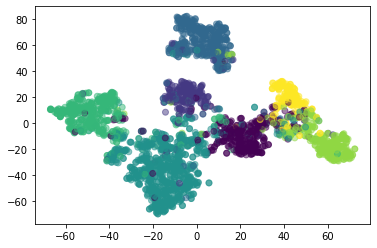

d:\Windows\Rotem\Projects\DS_Playground\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\Windows\Rotem\Projects\DS_Playground\venv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


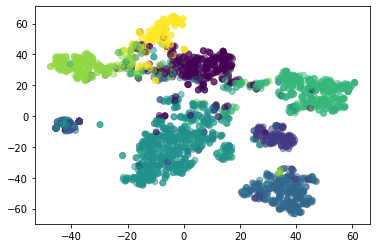

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
plt.scatter(*TSNE(2).fit_transform(x.cpu().detach().numpy()).transpose(), c=y.cpu().numpy(), alpha=0.5)
plt.show()
plt.scatter(*TSNE(2).fit_transform((data_compressed.invert_compress_matrix @ x_compressed).cpu().detach().numpy()).transpose(), c=y.cpu().numpy(), alpha=0.5)
plt.show()